## packages and imports

In [1]:
import jax.numpy as jnp
import numpy as np
import jax
import optax
from jaxopt import LBFGS
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import equinox as eqx
import scipy.linalg
from jax.nn.initializers import he_normal
from tqdm import tqdm
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
import time
from pathlib import Path

seed = 42
np.random.seed(seed)
key = jax.random.key(seed)

# trunk network parameters
num_bases = 10
num_trunk_epochs = 30000
lr = 1e-3
num_LBFGS_epochs = 5000
#t_stride = 1
eps = 1e-8 # to prevent loss overflow



print("\nconfiguring backend...")
jax.config.update("jax_platform_name", "metal")


print("backend selected:\n", jax.default_backend())
print("active devices:\n", jax.devices())
print("--------------------\n")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


configuring backend...
backend selected:
 METAL
active devices:
 [METAL(id=0)]
--------------------



W0000 00:00:1769022164.460643 9088906 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1769022164.481481 9088906 service.cc:145] XLA service 0x104b90150 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769022164.481493 9088906 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1769022164.483011 9088906 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1769022164.483019 9088906 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


In [2]:
## EQUINOX CLASS DEFINITIONS
# Linear Model (Wx + b)
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key, initializer = he_normal()):
        wkey, bkey = jax.random.split(key)
        self.weight = initializer(wkey, (out_size, in_size), dtype=jnp.float32)
        self.bias = jnp.zeros((out_size,), dtype=jnp.float32)

    def __call__(self, x):
        return self.weight @ x + self.bias


# Basic MultiLayer Perceptron Primitive
class MLP(eqx.Module):
    layers: list
    activations: list

    def __init__(self, architecture, key, activation = jax.nn.relu, initializer = he_normal()):
        """
        architecture: List[in, hidden1, hidden2, ..., out]
        key: random key
        activation: jax.nn act fxn
        """
        keys = jax.random.split(key, len(architecture) - 1)
        self.layers = [
            Linear(architecture[i], architecture[i+1], keys[i], initializer = initializer) for i in range(len(architecture) - 1)]
        self.activations = [activation] * (len(self.layers) - 1) + [eqx.nn.Identity()] # no activation on last layer

    def __call__(self, x):
        for layer, act in zip(self.layers, self.activations):
            x = act(layer(x))
        return x

## loading dataset

In [3]:
# load external dataset
# NOTE we're loading t, and subsampling every t_stride steps
dataset = np.load('/Users/haydenoutlaw/Documents/Research/opnet/deep-operator-networks/data/burgers_dataset.npz', allow_pickle = True)
t_grid = jnp.array(dataset['t'])
x_grid = jnp.array(dataset['x'])
print("grid is (t,x) = ", len(t_grid), len(x_grid))

data = dataset['samples']
u = np.array([i['params'] for i in data])
s = np.array([i['solution'] for i in data]) # s is shape (n,t,x)

# disabled functionality for train/test split for now
#n_samp = len(data)
#train_indices, test_indices = train_test_split(np.arange(n_samp), test_size = 0.0, random_state = seed)
#u_train, u_test = jnp.array(u[train_indices]), jnp.array(u[test_indices])
#s_train, s_test = jnp.array(s[train_indices]), jnp.array(s[test_indices])



grid is (t,x) =  201 201


In [4]:
u_train, s_train = u,s
print('label dataset size is (n, coord) = ', u_train.shape)
print('input dataset size is (n, x, t) = ', s_train.shape)

output_tr = jnp.transpose(s_train, axes=(1,2,0)) 
print(f"subsampled dataset size is (t,x,n) = {output_tr.shape}")

label dataset size is (n, coord) =  (441, 2)
input dataset size is (n, x, t) =  (441, 201, 201)
subsampled dataset size is (t,x,n) = (201, 201, 441)


In [5]:
tt,xx = jnp.meshgrid(t_grid, x_grid)
tx_grid = jnp.concatenate([tt.flatten()[:,None], xx.flatten()[:,None]], axis=1) #xt_grid[:,1] is x, xt_grid[:,0] is t
print("tx_grid is of shape (n, coord) = ",tx_grid.shape)

tx_grid is of shape (n, coord) =  (40401, 2)


## initializing model, loss_fn

In [6]:
u_dim = 2 # in this case, two 
y_dim = 2 # (t,x)
# define architectures for component networks
trunk_arch  = [y_dim, 40, 40, num_bases] 

key, subkey_t, subkey_A = jax.random.split(key, num=3)
trunk_model = MLP(trunk_arch,key = subkey_t)
A_model = jax.random.normal(subkey_A, (len(t_grid), num_bases, output_tr.shape[2])) # now A_model is a 3-tensor -- indexed as t, branch, n. as opposed to one matrix for entire xt domain
print("A_model is shape (t, num_bases, num_samples) = ", A_model.shape)

model = trunk_model, A_model

def loss_fn(model):
    trunk_model, A_model = model
    T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid) # trunk model matrix. output of model given input entire [x_grid, t_grid]
    print(T_MAT.shape, A_model.shape)
    pred_y = jnp.einsum("txN, tNk -> txk",T_MAT, A_model) # einsum is a tensor contraction. keep t index (time) and at each t index, do (x,N) times (N,k) -> (x,k). N = num_fxns, k = num_samples
    # pred_y[i,:,:] = T_mat[i,:,:] @ A_model[i,:,:], T_mat @ A_model for each individual time, analogous to vanilla case
    return jnp.mean((output_tr - pred_y) ** 2)/jnp.mean(output_tr ** 2) + eps # rel mean squared error

A_model is shape (t, num_bases, num_samples) =  (201, 10, 441)


In [7]:
%%time
opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

loss_hist = []
# standard eqx training step
@eqx.filter_jit
def train_step(model, opt_state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

s_time = time.time()
start_time = time.time()
for step in range(num_trunk_epochs):
    model, opt_state, loss = train_step(model, opt_state)
    loss_hist.append(float(loss)) # store as list
    if step % 10 == 0: # new carriage print, avoid tqdm for memory
        end_time = time.time()
        print(f"\rAdam step {step}: loss={float(loss):.3e}, {end_time-start_time:.2f}s", end="", flush=True)
        start_time = time.time()
e_time = time.time()
print(f"\nfinal adam loss: {loss:.3e}, total time: {e_time-s_time:.2f}s\n")

## LBFGS disabled for now. rebuild to match adam
opt = optax.lbfgs()

for step in range(num_LBFGS_epochs):
    model, opt_state, loss = train_step(model, opt_state)
    loss_hist.append(float(loss))
    if step % 100 == 0:
        print(
            f"\r{' ' * 80}\rLBFGS step {step}: loss={float(loss):.3e}",
            end="",
            flush=True
        )

(201, 201, 10) (201, 10, 441)
Adam step 29990: loss=9.735e-05, 0.14s
final adam loss: 9.110e-05, total time: 412.54s

LBFGS step 4900: loss=8.177e-05                                                 CPU times: user 1min 27s, sys: 21.9 s, total: 1min 49s
Wall time: 8min 1s


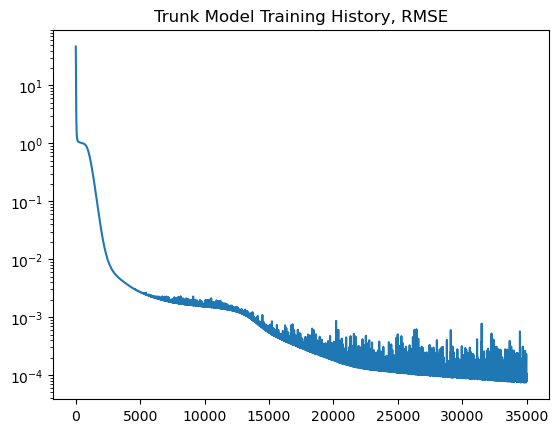

In [8]:
plt.plot(loss_hist)
plt.title(f"Trunk Model Training History, RMSE")
plt.yscale('log')

## QR Factorizations at Time Data

In [9]:
trunk_model, A_model = model
# SAME LOGIC AS ABOVE - T_MAT is trunk matrix output of entire [x_grid, t_grid]
T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid)
print("T_MAT is shape (t,x,n) = ", T_MAT.shape)

T_MAT is shape (t,x,n) =  (201, 201, 10)


In [10]:
# for index i of t_grid (subsampled here every 2)
for i in range(len(t_grid)):
    # take QR of T_MAT[i,:,:]
    Q,R = scipy.linalg.qr(T_MAT[i], mode = 'economic')
    # Q = scipy.linalg.lstsq(R.T,T_MAT_dense[i].T)[0].T
    # for j in range(0,Q.shape[1]):
    #     if jnp.mean((Q[j-1,:] - Q[j:] ) ** 2) >= jnp.mean((Q[j-1,:] + Q[j,:] ) ** 2):
    #         Q[j,:] = -1 * Q[j,:]
    #         R[:,j] = -1 * R[:,j]

    if i == 0:
        Q_MAT = Q[jnp.newaxis, :, :] # make the 3 tensor
        R_MAT = R[jnp.newaxis,:, :]
    else:
        Q_MAT = jnp.concatenate([Q_MAT, Q[jnp.newaxis, :, :]], axis = 0) # stack Q_MAT in first dimension
        R_MAT = jnp.concatenate([R_MAT, R[jnp.newaxis, :, :]], axis = 0)
    
print(f"Q_MAT is of shape (t,x,n) = {Q_MAT.shape}")
print(f"R_MAT is of shape {R_MAT.shape}")
print("shapes agree?", Q_MAT.shape == T_MAT.shape)

Q_MAT is of shape (t,x,n) = (201, 201, 10)
R_MAT is of shape (201, 10, 10)
shapes agree? True


In [11]:
Q_sign = np.array(Q_MAT, copy = True) #make np.array copies of tensors of QR factors
R_sign = np.array(R_MAT, copy = True)

# account for nonuniqueness in QR algorithm -- pick the closest Q columns by sign to ensure Q factors are time continuous
T = Q_sign.shape[0]
n = Q_sign.shape[2]

for k in range(1, T):          # time
    for j in range(n):         # basis index
        # choose sign to match previous time, just based on the first column
        if np.dot(Q_sign[k-1, :, j], Q_sign[k, :, j]) < 0:
            Q_sign[k, :, j] *= -1      # flip basis column of Q
            R_sign[k, j, :] *= -1      # flip corresponding row of R

# check for induced error on QR
for k in range(T):
    print(np.linalg.norm(Q_sign[k] @ R_sign[k] - T_MAT[k]))


2.3984203e-06
3.849474e-06
3.7090783e-06
1.1247429e-06
1.9543497e-06
1.2852349e-06
1.874408e-06
3.1024151e-06
2.4007943e-06
2.8447305e-06
1.0152054e-06
1.712289e-06
2.34116e-06
1.834116e-06
2.7945348e-06
1.8520284e-06
1.5789687e-06
1.3718627e-06
2.58175e-06
1.0496858e-06
1.7032929e-06
2.512222e-06
1.6141149e-06
1.8430649e-06
1.954091e-06
3.2100565e-06
1.7536718e-06
2.3228752e-06
3.9000884e-06
1.0475957e-06
9.262536e-07
2.1618105e-06
9.1414523e-07
4.0501377e-06
7.8540415e-07
1.1027374e-06
2.4874407e-06
1.6554897e-06
1.0348763e-06
4.4008866e-06
9.165871e-07
4.436831e-06
1.1394181e-06
1.0590016e-06
5.698645e-07
4.5192933e-06
9.569432e-07
1.4450735e-06
8.3841945e-07
9.873553e-07
2.1076285e-06
1.3210722e-06
8.360283e-07
6.5860434e-07
1.999095e-06
1.1060264e-06
3.7677319e-06
6.4431174e-07
8.005479e-07
2.6673533e-06
2.4761725e-06
5.8196764e-07
4.8458787e-06
4.1630083e-06
2.0344214e-06
4.871696e-07
6.8329103e-07
1.4193688e-06
2.688433e-06
1.1268136e-06
7.9772013e-07
3.1094298e-06
1.6114124e-06

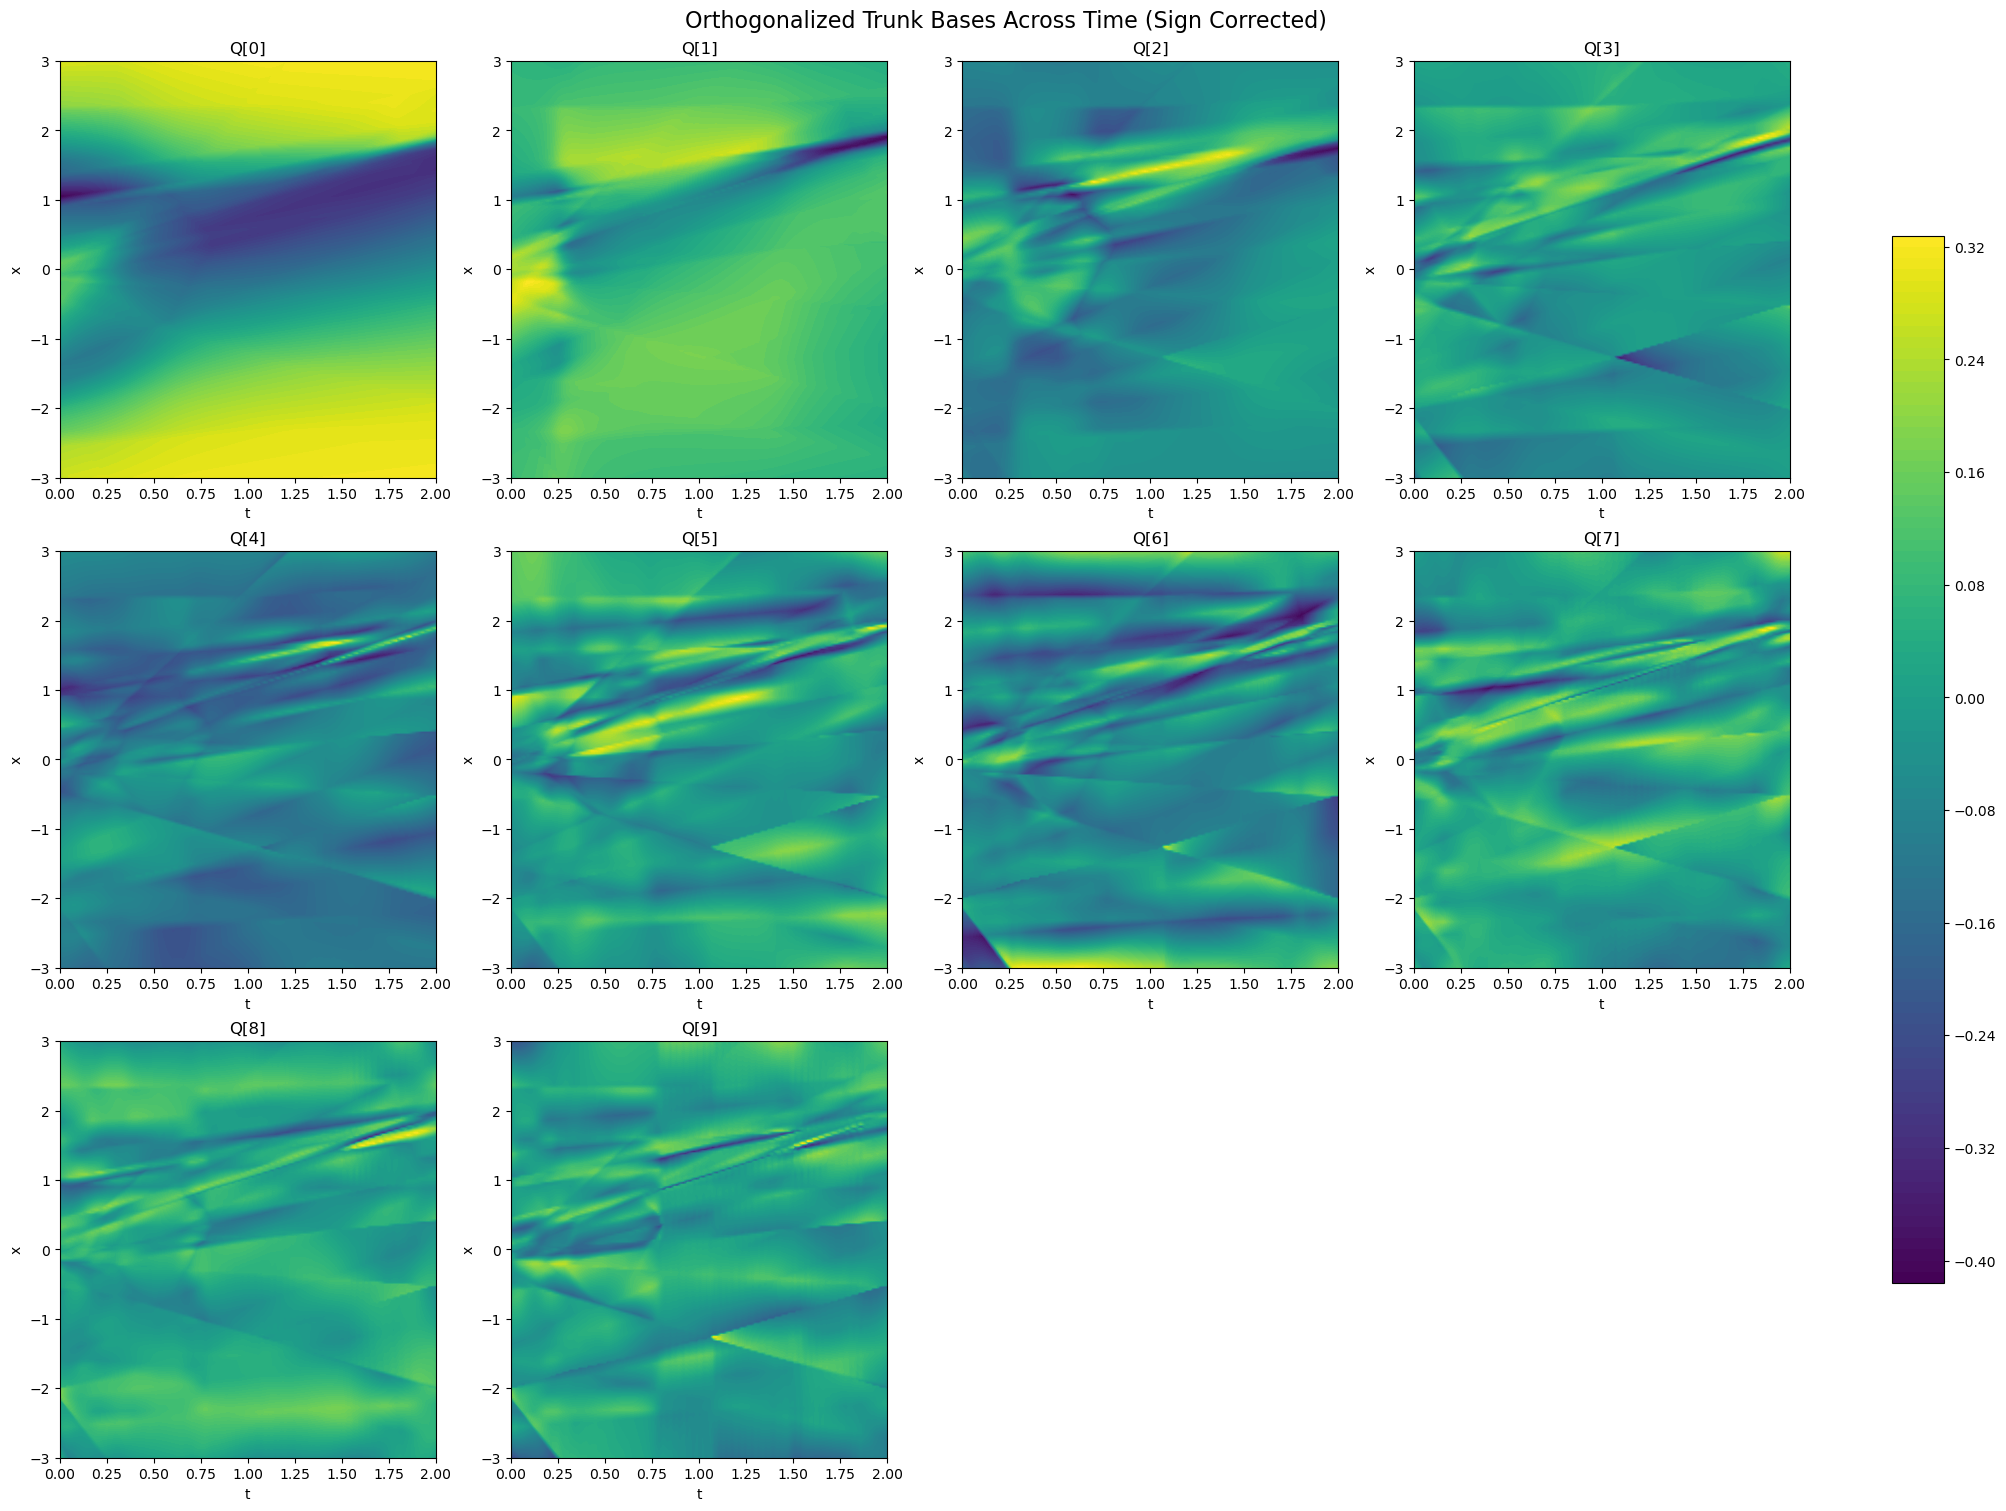

In [12]:
ncols = 4
nrows = int(np.ceil(num_bases / ncols))

T, X = np.meshgrid(t_grid, x_grid, indexing="ij")

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(5 * ncols, 5 * nrows),
    constrained_layout=True
)

axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        Q_k = Q_sign[:, :, k]

        # 2D top-down plot
        im = ax.contourf(T, X, Q_k, levels=100, cmap='viridis')

        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
    else:
        ax.axis("off")

fig.suptitle(
    f"Orthogonalized Trunk Bases Across Time (Sign Corrected)",
    fontsize=16
)

# attach a single colorbar for the whole figure
cbar = fig.colorbar(im, ax=axes.tolist(), shrink=0.75)

plt.show()


## save out Q,R factors and data

In [13]:
save_path = Path("qr_factors_cont.npz")

# export data to .npz arrays
np.savez_compressed(
    save_path,
    Q = np.asarray(Q_sign),
    R = np.asarray(R_sign),
    t_grid = np.asarray(t_grid),
    x_grid = np.asarray(x_grid)
)

print("exported to:", save_path)

exported to: qr_factors_cont.npz


## .gif renders

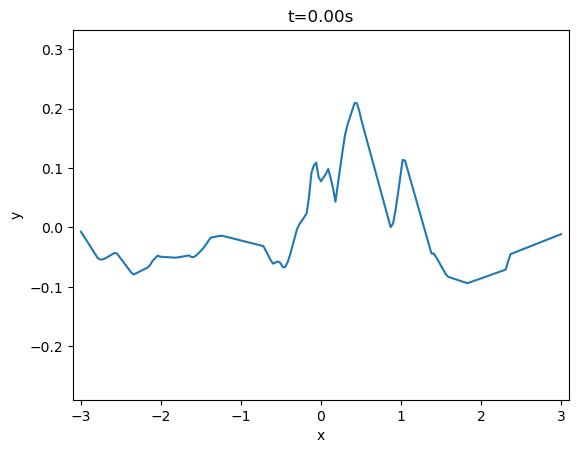

In [14]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.animation as animation

basis_idx = 2
fig, ax = plt.subplots()
line2 = ax.plot(x_grid,Q_sign[0,:,basis_idx])[0]
vmin, vmax = jnp.min(Q_sign[:,:,basis_idx]), jnp.max(Q_sign[:,:,basis_idx])
ax.set(xlim=[-3.1, 3.1], ylim=[vmin, vmax], xlabel='x', ylabel='y')
# ax.legend()

def update(frame):
    line2.set_xdata(x_grid)
    line2.set_ydata(Q_sign[frame,:,basis_idx])
    # update the title:
    ax.set_title(f't={t_grid[frame]:.2f}s')
    return line2

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(t_grid) -1 , interval=50)
ani.save(filename=f"DON_basis_{basis_idx}.gif", writer="pillow")

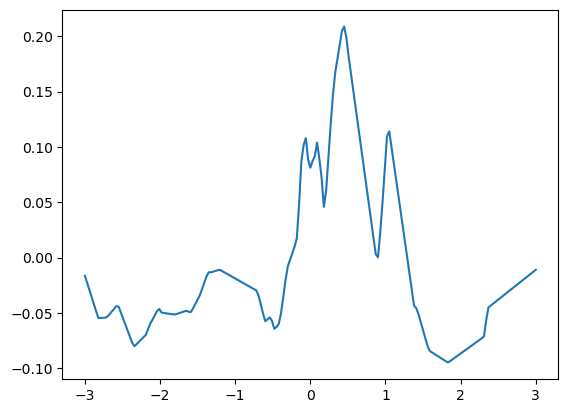

In [15]:
plt.plot(x_grid,Q_MAT[1,:,2])[0]

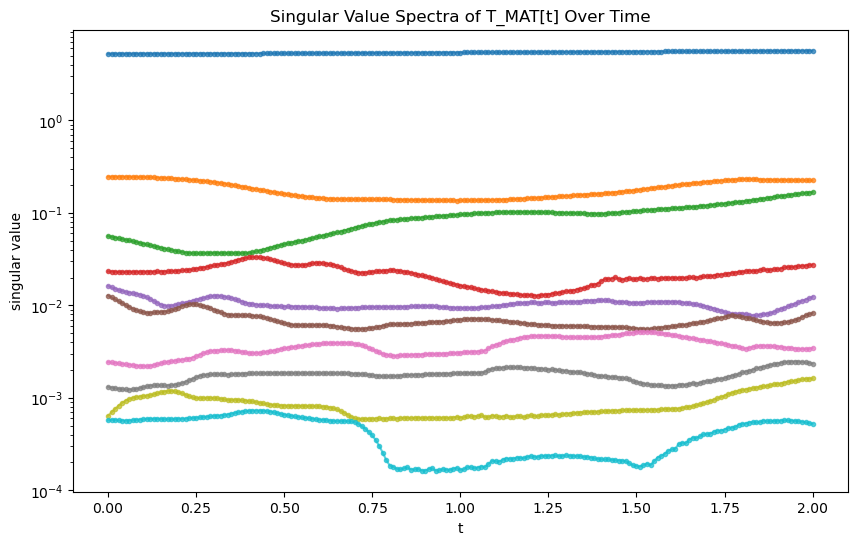

In [16]:
num_times = T_MAT.shape[0]

# compute SVD spectra at all times
sv_list = []
for i in range(num_times):
    _, S, _ = scipy.linalg.svd(np.array(T_MAT[i]), full_matrices=False)
    sv_list.append(S)

sv_array = np.vstack(sv_list)   # shape (t, num_bases)

plt.figure(figsize=(10,6))

for k in range(sv_array.shape[1]):
    plt.plot(t_grid, sv_array[:, k], '.-', alpha=0.7)

plt.yscale('log')
plt.xlabel("t")
plt.ylabel("singular value")
plt.title("Singular Value Spectra of T_MAT[t] Over Time")
#plt.grid(True, which='both', ls='--', alpha=0.3)

plt.show()

In [17]:
T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid) # trunk model matrix. output of model given input entire [x_grid, t_grid]
print(T_MAT.shape, A_model.shape)
pred_y = jnp.einsum("txN, tNk -> txk",T_MAT, A_model)

(201, 201, 10) (201, 10, 441)


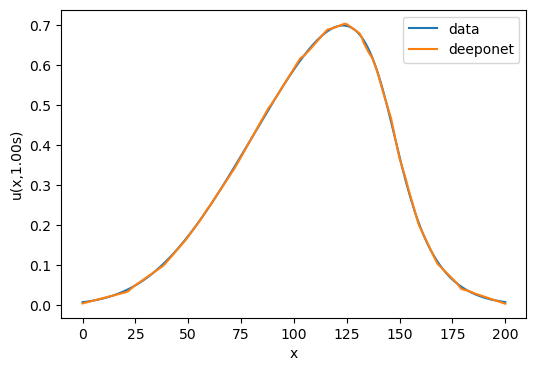

In [18]:
j= 100
idx_param = 20
# print(T.shape, X.shape, pred_y[:,:,0] - output_tr[:,:,0])
plt.figure(figsize=(6,4))
plt.plot(output_tr[j,:,idx_param], label='data')
plt.plot(pred_y[j,:,idx_param], label='deeponet')
plt.xlabel("x")
plt.ylabel(f"u(x,{t_grid[j]:.2f}s)")
plt.legend()
# plt.title("u(t, x)")
# plt.colorbar(label="u")
plt.show()


## branch network training

In [19]:
K = A_model.shape[1] # number of basis functions
N = A_model.shape[2] # number of systems 


# define architectures for component networks
branch_arch = [u_train.shape[1] + 1, 40, 40, K] 

key, subkey_t, subkey_A = jax.random.split(key, num=3)
branch_model = MLP(branch_arch,key = subkey_t)

print(Q_sign.shape) # Q is (201,201,10) = (t,x,basis)


B_tnk = jax.vmap(
    lambda t: jax.vmap(
        lambda u: branch_model(jnp.concatenate([u, jnp.array([t])]))
    )(u_train)   # u_train shape (N,2)
)(t_grid)        # (T,N,K)

B_MAT = jnp.swapaxes(B_tnk, 1, 2)  # (T, K, N)


print("Branch Model is shape:", B_MAT.shape)


print("R Tensor is shape  (t, trunk #, trunk #) =", R_sign.shape) # R is t, N, N
print("A Tensor is shape (t, trunk #, n) =", A_model.shape) # A is t, basis idx, n


RA_model = jnp.einsum("tij, tjk -> tik", R_sign, A_model) ## IS THIS LOGIC RIGHT??
print("RA Tensor is shape:", RA_model.shape)


(201, 201, 10)
Branch Model is shape: (201, 10, 441)
R Tensor is shape  (t, trunk #, trunk #) = (201, 10, 10)
A Tensor is shape (t, trunk #, n) = (201, 10, 441)
RA Tensor is shape: (201, 10, 441)


In [20]:

RA_target = jnp.asarray(RA_model)  # (T, K, N), frozen data

def branch_loss_fn(branch_model, RA_target, u_train, t_grid, eps=1e-8): # vmap u_train (parameters) and t_grid through branch model -- loss is B_NN - R^*A^*
    B_tnK = jax.vmap(
        lambda t: jax.vmap(
            lambda u: branch_model(jnp.concatenate([u, jnp.array([t])]))
        )(u_train)
    )(t_grid)  # (T, N, K)

    B_MAT = jnp.swapaxes(B_tnK, 1, 2)  # (T, K, N) # does require an internal tensor transpose
    return jnp.mean((B_MAT - RA_target) ** 2) / (jnp.mean(B_MAT ** 2) + eps)

# ---- optimizer ----
opt = optax.adam(lr)

# IMPORTANT: init on branch_model only
opt_state = opt.init(eqx.filter(branch_model, eqx.is_inexact_array))

@eqx.filter_jit # does require filter value and grad because of frozen RA target
def branch_train_step(branch_model, opt_state, RA_target, u_train, t_grid):
    loss, grads = eqx.filter_value_and_grad(branch_loss_fn)( 
        branch_model, RA_target, u_train, t_grid
    )
    updates, opt_state = opt.update(grads, opt_state, branch_model)
    branch_model = eqx.apply_updates(branch_model, updates)
    return branch_model, opt_state, loss



In [21]:
%%time
#---- training loop ----
branch_loss_hist = []


for step in range(num_trunk_epochs):
    branch_model, opt_state, loss = branch_train_step(
        branch_model, opt_state, RA_target, u_train, t_grid
    )
    branch_loss_hist.append(float(loss))
    if step % 10 == 0:
        end_time = time.time()
        print(f"\rAdam step {step}: loss={float(loss):.3e}",
              end="", flush=True)

print(f"\nfinal adam loss: {float(loss):.3e}\n")

Adam step 29990: loss=8.417e-05
final adam loss: 8.465e-05

CPU times: user 1min 28s, sys: 20.2 s, total: 1min 49s
Wall time: 5min


In [22]:
u_rand, s_rand = u_train[20], s_train[20] # s is true values, u is input parameters

def branch_over_time(branch_model, u, t_grid):
    # u: (u_dim,), t_grid: (T,), returns (T, K)
    return jax.vmap(lambda t: branch_model(jnp.concatenate([u, jnp.array([t])])))(t_grid)

def compute_QHb_grid(Q_sign, branch_model, u, t_grid):
    """
    Q_sign: (T, X, K)  storing Q(t,x,k)
    u:      (u_dim,)
    returns: (T, X) with entries sum_k conj(Q[t,x,k]) * b[t,k]
    """
    b_tk = branch_over_time(branch_model, u, t_grid)          # (T, K)
    grid_tx = jnp.einsum("txk,tk->tx", jnp.conj(Q_sign), b_tk)  # (T, X)
    return grid_tx

rand_pred_tx = compute_QHb_grid(Q_sign, branch_model, jnp.array(u_rand), jnp.array(t_grid))
print(rand_pred_tx.shape)  # (T, X)

(201, 201)


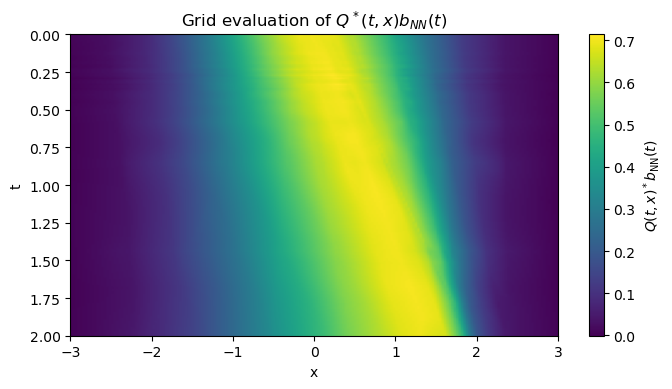

In [ ]:
plt.figure(figsize=(7, 4))
plt.imshow(
    rand_pred_tx,
    extent=[x_grid[0], x_grid[-1], t_grid[-1], t_grid[0]],
    aspect="auto",
    origin="upper"
)
plt.colorbar(label=r"$Q(t,x)^* b_{\mathrm{NN}}(t)$")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Grid evaluation of $Q^*(t,x)b_{NN}(t)$")
plt.tight_layout()
plt.show()


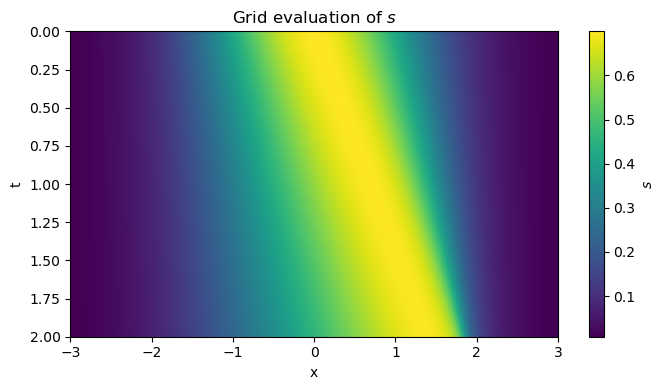

In [24]:
plt.figure(figsize=(7, 4))
plt.imshow(
    s_rand,
    extent=[x_grid[0], x_grid[-1], t_grid[-1], t_grid[0]],
    aspect="auto",
    origin="upper"
)
plt.colorbar(label=r"$s$")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Grid evaluation of $s$")
plt.tight_layout()
plt.show()


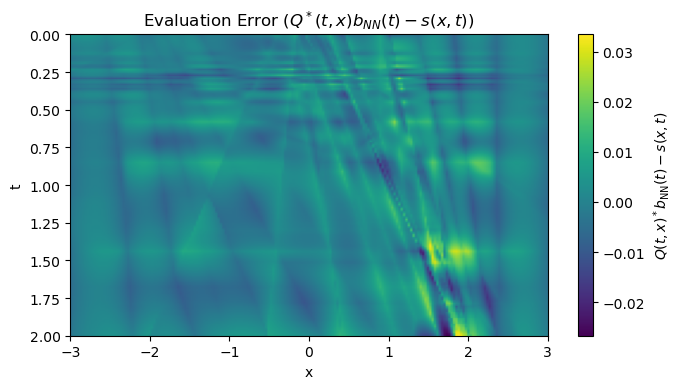

In [25]:
plt.figure(figsize=(7, 4))
plt.imshow(
    rand_pred_tx - s_rand,
    extent=[x_grid[0], x_grid[-1], t_grid[-1], t_grid[0]],
    aspect="auto",
    origin="upper"
)
plt.colorbar(label=r"$Q(t,x)^* b_{\mathrm{NN}}(t) - s(x,t)$")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Evaluation Error ($Q^*(t,x)b_{NN}(t) - s(x,t)$)")
plt.tight_layout()
plt.show()
